# Queue Prediction Model

This notebook converts the provided Flask-based Python script into a Jupyter Notebook format. The notebook is organized into sections for better readability and maintainability.

In [1]:
import pandas as pd
import urllib.request
import json
import holidays
import logging
from datetime import datetime, timedelta
import os
import time
from flask import Flask, request, jsonify
from flask_caching import Cache
from flask_crontab import Crontab
import joblib
import numpy as np
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from supabase import create_client, Client
from dotenv import load_dotenv
from sklearn.base import BaseEstimator, RegressorMixin
import urllib.error
import matplotlib.pyplot as plt

/Users/ottosensimon/miniconda3/envs/mlapi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %%
# Load environment variables
load_dotenv()

True

In [3]:
# %%
# Logging Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# %%
# Environment & Global Variables

UseSupabase = 1  # If 1 then Yes, if 0 then No. Do not use Supabase for production

CPHAPI_HOST = os.environ.get("CPHAPI_HOST", "https://waitport.com/api/v1/all")

# A dictionary mapping each airport code to its local holiday calendar
airport_holiday_map = {
    'AMS': holidays.Netherlands(),
    'ARN': holidays.Sweden(),
    'CPH': holidays.Denmark(),
    'DUB': holidays.Ireland(),
    'DUS': holidays.Germany(),
    'FRA': holidays.Germany(),
    'IST': holidays.Turkey(),
    'LHR': holidays.UnitedKingdom(),
    'MUC': holidays.Germany(),
    'OSL': holidays.Norway(),
}

# Valid airports for reference
VALID_AIRPORTS = list(airport_holiday_map.keys())

In [5]:
# %%
# Fallback Regressor that Always Returns 5

class FallbackRegressor(BaseEstimator, RegressorMixin):
    """A fallback regressor that always returns 5."""
    def __init__(self, constant=5):
        self.constant = constant

    def fit(self, X, y=None):
        return self  # No actual fitting

    def predict(self, X):
        return np.full(shape=(len(X),), fill_value=self.constant)

In [6]:
# %%
# Utility: Get Data from Supabase (Full)

def get_data_via_supabase_client() -> pd.DataFrame:
    """
    Fetch data from Supabase. Adjust table/columns/filters as needed.
    """
    supabase_url = os.environ.get("SUPABASE_URL", "")
    supabase_key = os.environ.get("SUPABASE_KEY", "")
    if not supabase_url or not supabase_key:
        raise ValueError("Missing SUPABASE_URL or SUPABASE_KEY environment variables.")
    
    supabase: Client = create_client(supabase_url, supabase_key)
    
    response = (
        supabase
        .table("waitingtime")
        .select("id,queue,timestamp,airport")
        .eq("airport", "CPH")  # Only select CPH
        .neq("airport", "BER")  # Exclude BER
        .order("id", desc=True)
        .execute()
    )
    df = pd.DataFrame(response.data)
    return df

In [13]:
# %%
# Utility: Get Data from Local Database (Full) - For reference

def get_data_via_local_database() -> pd.DataFrame:
    """
    Pulls *all* data for each airport. This can be quite large/slow.
    """
    start_time_load_data = time.time()
    
    # List of airports
    airports = ["CPH", "OSL", "ARN", "DUS", "FRA", "MUC", "LHR", "AMS", "DUB", "IST"]
    
    dfs = []
    for airport_code in airports:
        url = (
            f"{CPHAPI_HOST}"
            f"?order=id.desc&select=id,queue,timestamp,airport"
            f"&airport=eq.{airport_code}"
        )
        df_ap = pd.read_json(url, verify=False)
        dfs.append(df_ap)
    
    df = pd.concat(dfs, ignore_index=True)
    print("Loaded ALL data successfully in %.2f seconds " % (time.time() - start_time_load_data))
    return df

In [14]:
# %%
# NEW Utility: Get Data from Local Database (Light) - Only last 7 days

def get_data_via_local_database_light() -> pd.DataFrame:
    """
    Pull only the last 7 days of data for each airport. 
    Since entries occur every 5 minutes, you get ~2016 rows/airport/week,
    for a total ~20k rows across 10 airports, which is much faster to load.
    Adjust the time window if needed.
    """
    start_time_load_data = time.time()
    
    # How many days of data for "light" fetch
    num_days = 7
    
    # Calculate the start time in UTC (e.g., 7 days ago)
    end_time_utc = datetime.utcnow()
    start_time_utc = end_time_utc - timedelta(days=num_days)
    start_time_str = start_time_utc.isoformat()  # e.g. 2025-02-03T12:34:56.789123

    airports = ["CPH", "OSL", "ARN", "DUS", "FRA", "MUC", "LHR", "AMS", "DUB", "IST"]
    
    dfs = []
    for airport_code in airports:
        url = (
            f"{CPHAPI_HOST}"
            f"?order=id.desc"
            f"&select=id,queue,timestamp,airport"
            f"&airport=eq.{airport_code}"
            f"&timestamp=gte.{start_time_str}"
        )
        df_ap = pd.read_json(url)
        dfs.append(df_ap)
    
    df = pd.concat(dfs, ignore_index=True)
    print("Loaded LIGHT data (last 7 days) in %.2f seconds " % (time.time() - start_time_load_data))
    return df

In [15]:
# %%
# Utility Functions

def add_holiday_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a 'Holiday' feature (1/0) indicating if a day is a local holiday
    for the airport corresponding to each row.
    """
    def is_local_holiday(row):
        for ap, holiday_obj in airport_holiday_map.items():
            if ap in row.index and row[ap] == 1:
                dt = row.name.date()
                return int(dt in holiday_obj)
        return 0

    df['Holiday'] = df.apply(is_local_holiday, axis=1)
    return df

def _compute_rolling_features(df: pd.DataFrame, airport_code: str) -> None:
    """
    For a given airport_code, create two new columns in df:
      - '{airport_code}_rolling_24h': mean queue of the last 24 hours
      - '{airport_code}_rolling_7d':  mean queue of the last 7 days
    Each row's rolling average is based on that airport's data up to that row's timestamp index.
    """
    airport_data = df[df[airport_code] == 1].copy()
    if airport_data.empty:
        return

    # Sort by time to ensure proper rolling
    airport_data.sort_index(inplace=True)

    airport_data['rolling_24h'] = (
        airport_data['queue']
            .rolling('24h', min_periods=1)
            .mean()
    )
    airport_data['rolling_7d'] = (
        airport_data['queue']
            .rolling('7d', min_periods=1)
            .mean()
    )

    df.loc[airport_data.index, f'{airport_code}_rolling_24h'] = airport_data['rolling_24h']
    df.loc[airport_data.index, f'{airport_code}_rolling_7d'] = airport_data['rolling_7d']

In [16]:
# %%
# Data Fetching with Caching

def get_data():
    """
    Fetch the *full* dataset from Supabase (or local API) and preprocess.
    """
    start_time = time.time()
    logger.info("Fetching full dataset...")

    try:
        if UseSupabase == 1:
            dataframe = get_data_via_supabase_client()
        else:
            dataframe = get_data_via_local_database()
    except Exception as e:
        logger.error(f"Error fetching data: {e}")
        return pd.DataFrame()

    # Convert timestamps from UTC to Europe/Copenhagen
    StartTime = pd.to_datetime(dataframe["timestamp"], utc=True)
    StartTime = StartTime.dt.tz_convert('Europe/Copenhagen')
    dataframe["timestamp"] = StartTime
    
    df = dataframe.set_index("timestamp")
    df.sort_index(inplace=True)
    df.index = df.index + pd.to_timedelta(df.groupby(level=0).cumcount(), unit='ns')

    df['year'] = df.index.year
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday

    df_airport = pd.get_dummies(df['airport'])
    df = pd.concat([df, df_airport], axis=1)

    for airport_code in VALID_AIRPORTS:
        if airport_code in df.columns:
            _compute_rolling_features(df, airport_code)

    df = add_holiday_feature(df)

    if 'id' in df.columns:
        df.drop(['id'], axis=1, inplace=True)

    df['queue'] = df['queue'].apply(lambda x: np.nan if x > 1e10 else x)
    df.dropna(subset=['queue'], inplace=True)

    logger.info("Fetched & preprocessed FULL dataset in %.2f seconds", time.time() - start_time)
    return df

def get_data_light():
    """
    Fetch a *light* dataset (e.g., last 7 days).
    Preprocess similarly (convert timestamps, add time features, etc.).
    """
    start_time = time.time()
    logger.info("Fetching light dataset...")

    try:
        if UseSupabase == 1:
            # If you prefer a light approach for Supabase, you can create a similar function
            # that filters data by time or row count from Supabase. For now, fallback:
            dataframe = get_data_via_supabase_client()
        else:
            dataframe = get_data_via_local_database_light()
    except Exception as e:
        logger.error(f"Error fetching light data: {e}")
        return pd.DataFrame()

    StartTime = pd.to_datetime(dataframe["timestamp"], utc=True)
    StartTime = StartTime.dt.tz_convert('Europe/Copenhagen')
    dataframe["timestamp"] = StartTime
    
    df = dataframe.set_index("timestamp")
    df.sort_index(inplace=True)
    df.index = df.index + pd.to_timedelta(df.groupby(level=0).cumcount(), unit='ns')

    df['year'] = df.index.year
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday

    df_airport = pd.get_dummies(df['airport'])
    df = pd.concat([df, df_airport], axis=1)

    for airport_code in VALID_AIRPORTS:
        if airport_code in df.columns:
            _compute_rolling_features(df, airport_code)

    df = add_holiday_feature(df)

    if 'id' in df.columns:
        df.drop(['id'], axis=1, inplace=True)

    df['queue'] = df['queue'].apply(lambda x: np.nan if x > 1e10 else x)
    df.dropna(subset=['queue'], inplace=True)

    logger.info("Fetched & preprocessed LIGHT dataset in %.2f seconds", time.time() - start_time)
    return df

In [17]:
# %%
# Separate Model Training

"""
Train a separate XGBoost model for each airport in VALID_AIRPORTS.
If no data or training fails, store a FallbackRegressor for that airport.
"""
start_time = time.time()
logger.info("Starting model training for each airport...")

df = get_data()
if df.empty:
    logger.warning("No data returned. Saving fallback models for all airports.")
    for ap in VALID_AIRPORTS:
        fallback = FallbackRegressor(constant=5)
        joblib.dump(fallback, f'trained_model_{ap}.joblib')

df.sort_index(inplace=True)
df = df.reindex(sorted(df.columns), axis=1)

for airport_code in VALID_AIRPORTS:
    if airport_code not in df.columns:
        logger.warning(f"No column for {airport_code}. Saving fallback model.")
        fallback = FallbackRegressor()
        joblib.dump(fallback, f'trained_model_{airport_code}.joblib')
        continue

    airport_df = df[df[airport_code] == 1]
    if airport_df.empty:
        logger.warning(f"No data for airport {airport_code}, saving fallback.")
        fallback = FallbackRegressor()
        joblib.dump(fallback, f'trained_model_{airport_code}.joblib')
        continue

    # Ensure rolling columns exist
    rolling_cols = [f'{airport_code}_rolling_24h', f'{airport_code}_rolling_7d']
    for rc in rolling_cols:
        if rc not in airport_df.columns:
            airport_df[rc] = 0.0

    cutoff = int(len(airport_df) * 0.9)
    train_df = airport_df.iloc[:cutoff]
    test_df  = airport_df.iloc[cutoff:]
    logger.info(f"{airport_code} - train size: {len(train_df)}, test size: {len(test_df)}")

    if len(train_df) < 10:
        logger.warning(f"Not enough training rows for {airport_code}, using fallback.")
        fallback = FallbackRegressor()
        joblib.dump(fallback, f'trained_model_{airport_code}.joblib')
        continue

    try:

        # Step 1: Reset the index to turn the timestamp index into a column
        train_df = train_df.reset_index()

        # Optional: Rename the new column if desired (e.g., 'timestamp')
        train_df = train_df.rename(columns={'index': 'timestamp'})

        # Step 2: The index is already reset to a default integer index after reset_index()
        train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
        if train_df['timestamp'].dt.tz is not None:
            train_df['timestamp'] = train_df['timestamp'].dt.tz_convert(None)
        train_df['timestamp'] = train_df['timestamp'].dt.floor('s')

        # (Optional) If you want the 'ID' column to be the first column
        # Rearrange the columns

        # Display the updated DataFrame

        data = TimeSeriesDataFrame.from_data_frame(
            train_df,
            id_column="airport",
            timestamp_column="timestamp"
        )

        data = data.convert_frequency(freq="30min")
        prediction_length = 48
        train_data, test_data = data.train_test_split(prediction_length)

        model = TimeSeriesPredictor(
            prediction_length=48,
            target="queue",
            eval_metric="MASE",
        )

        model.fit(
            train_data,
            presets="medium_quality",
            time_limit=600,
        )

        logger.info(f"DONE TRAINING {airport_code}")

        # Uncomment below lines if you want to evaluate the model
        # if not X_test.empty:
        #     y_pred = model.predict(X_test)
        #     mse = mean_squared_error(y_test, y_pred)
        #     logger.info(f"{airport_code} - MSE: {mse:.2f}")
        predictions = model.predict(train_data)
        print(predictions.head())

        joblib.dump(model, f'trained_model_{airport_code}.joblib')
        logger.info(f"Model for {airport_code} saved.")
    except Exception as e:
        logger.error(f"Error training {airport_code}, using fallback. Error: {e}")
        fallback = FallbackRegressor()
        joblib.dump(fallback, f'trained_model_{airport_code}.joblib')

logger.info("Finished training in %.2f seconds", time.time() - start_time)

INFO:__main__:Starting model training for each airport...
INFO:__main__:Fetching full dataset...
ERROR:__main__:Error fetching data: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1147)
INFO:__main__:Finished training in 0.30 seconds


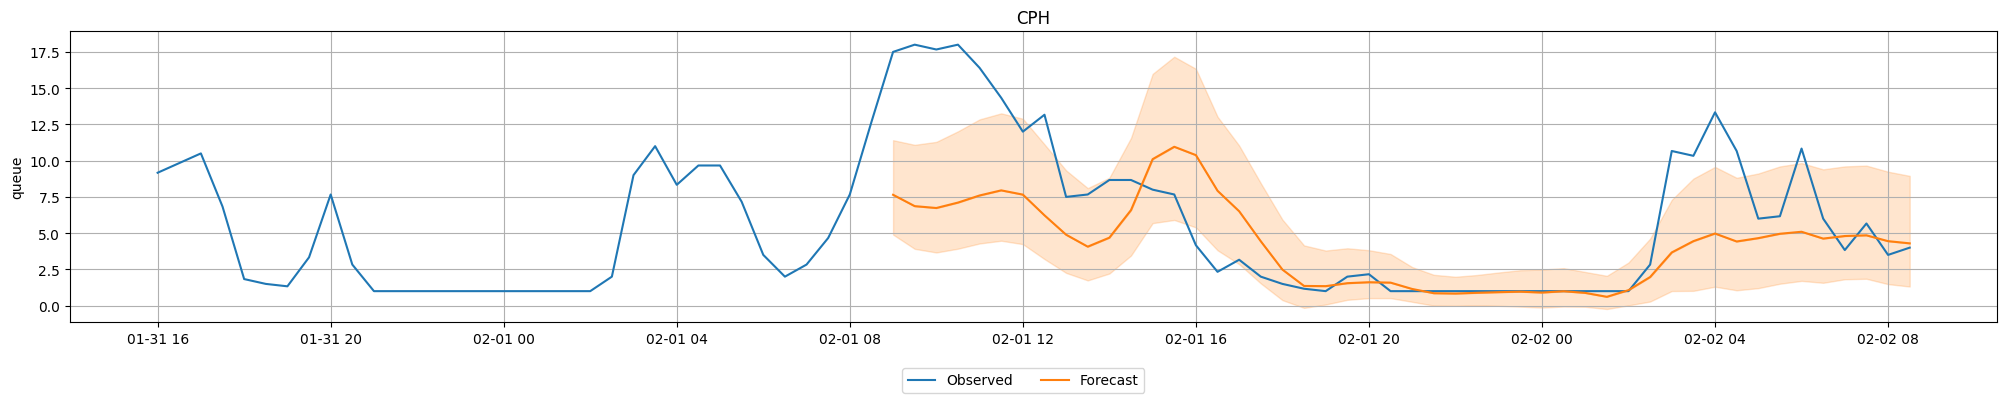

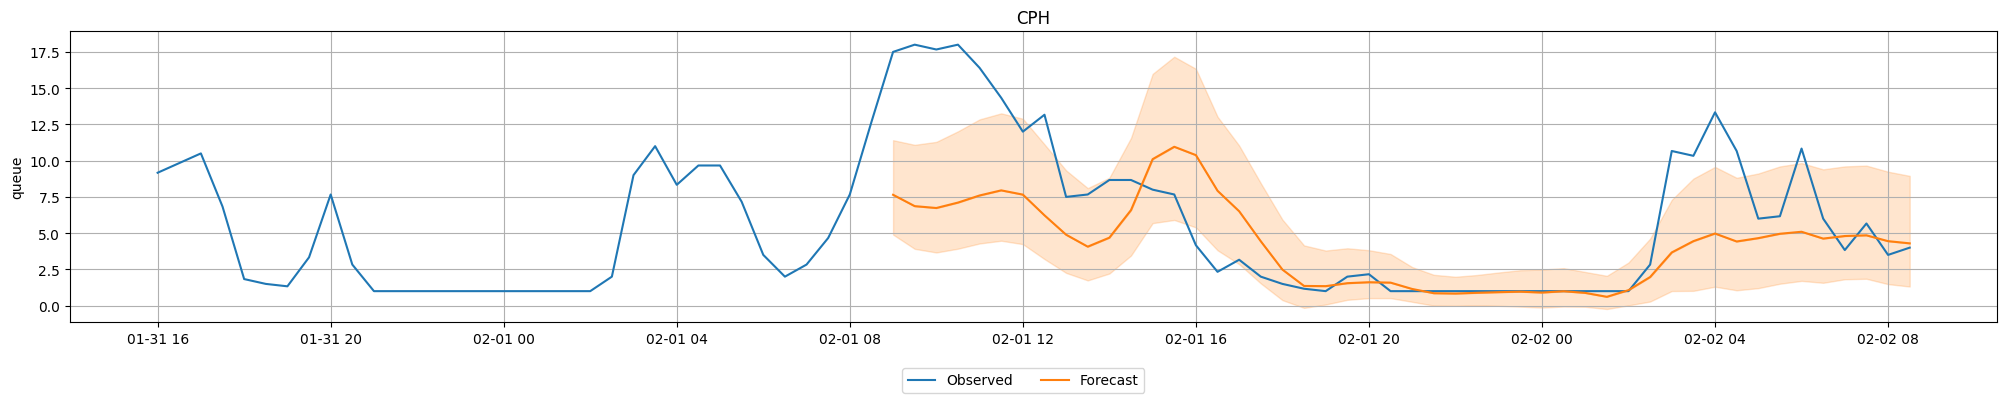

In [38]:
#predictions = model.predict(train_data)
#print(predictions.head())

model.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    quantile_levels=[0.2, 0.8],
    max_history_length=200,
)


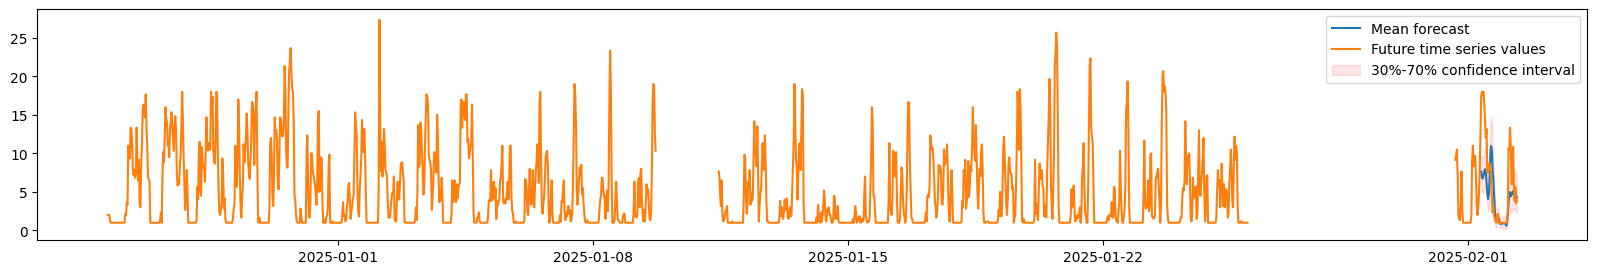

In [ ]:

plt.figure(figsize=(20, 3))

item_id = "CPH"
#y_past = train_data.loc[item_id]["queue"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["queue"]

#plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.3"], y_pred["0.7"], color="red", alpha=0.1, label=f"30%-70% confidence interval"
)

plt.legend()
plt.ion()
plt.show()


In [ ]:
# %%
def load_model_for_airport(airport_code: str):
    """
    Load model from 'trained_model_{airport_code}.joblib'.
    If file not found or error, return FallbackRegressor(5).
    """
    try:
        model = joblib.load(f"trained_model_{airport_code}.joblib")
        logger.info(f"Loaded model for {airport_code}.")
        return model
    except Exception as e:
        logger.error(f"Could not load model for {airport_code}, using fallback. Error: {e}")
        return FallbackRegressor(constant=5)

In [ ]:
# %%
# Prediction Logic

def predict_queue(timestamp_df: pd.DataFrame) -> float:
    """
    Predict queue length for a single row input with ['timestamp', 'airport'].
    If no model/data, returns fallback=5.
    """
    airport = timestamp_df["airport"].iloc[0]
    model = load_model_for_airport(airport)

    # 1) Convert timestamp to datetime + localize
    modeldatetime = pd.to_datetime(timestamp_df["timestamp"], utc=True)
    modeldatetime = modeldatetime.dt.tz_convert('Europe/Copenhagen')

    timestamp_df["timestamp"] = modeldatetime
    timestamp_df = timestamp_df.set_index(timestamp_df.timestamp)

    # 2) Date/time features
    timestamp_df['year'] = timestamp_df.index.year
    timestamp_df['hour'] = timestamp_df.index.hour
    timestamp_df['day'] = timestamp_df.index.day
    timestamp_df['month'] = timestamp_df.index.month
    timestamp_df['weekday'] = timestamp_df.index.weekday

    # 3) One-hot
    for ap in VALID_AIRPORTS:
        timestamp_df[ap] = 1 if ap == airport else 0

    # 4) Rolling features from LIGHT data
    df_light = get_data_light()
    if df_light.empty:
        rolling_24h_val = 0.0
        rolling_7d_val  = 0.0
    else:
        cutoff_time = modeldatetime.iloc[0]
        airport_df = df_light[(df_light[airport] == 1) & (df_light.index <= cutoff_time)].copy()
        if airport_df.empty:
            rolling_24h_val = 0.0
            rolling_7d_val  = 0.0
        else:
            airport_df.sort_index(inplace=True)
            airport_df['rolling_24h'] = airport_df['queue'].rolling('24h', min_periods=1).mean()
            airport_df['rolling_7d']  = airport_df['queue'].rolling('7d',  min_periods=1).mean()

            last_row = airport_df.iloc[-1]
            rolling_24h_val = last_row['rolling_24h'] if not pd.isna(last_row['rolling_24h']) else 0.0
            rolling_7d_val  = last_row['rolling_7d']  if not pd.isna(last_row['rolling_7d']) else 0.0

    timestamp_df[f'{airport}_rolling_24h'] = rolling_24h_val
    timestamp_df[f'{airport}_rolling_7d']  = rolling_7d_val

    # For other airports, set rolling to 0
    for ap in VALID_AIRPORTS:
        if ap != airport:
            timestamp_df[f'{ap}_rolling_24h'] = 0.0
            timestamp_df[f'{ap}_rolling_7d']  = 0.0

    # 5) Holiday feature
    timestamp_df = add_holiday_feature(timestamp_df)

    # 6) Drop 'timestamp' & 'airport'
    for col in ['timestamp']:
        if col in timestamp_df.columns:
            timestamp_df.drop(col, axis=1, inplace=True)

    # 7) Sort columns
    timestamp_df = timestamp_df.reindex(sorted(timestamp_df.columns), axis=1)

    # Step 1: Reset the index to turn the timestamp index into a column
    timestamp_df = timestamp_df.reset_index()

    # Optional: Rename the new column if desired (e.g., 'timestamp')
    timestamp_df = timestamp_df.rename(columns={'index': 'timestamp'})

    # Step 2: The index is already reset to a default integer index after reset_index()
    timestamp_df['timestamp'] = pd.to_datetime(timestamp_df['timestamp'])
    if timestamp_df['timestamp'].dt.tz is not None:
        timestamp_df['timestamp'] = timestamp_df['timestamp'].dt.tz_convert(None)
    timestamp_df['timestamp'] = timestamp_df['timestamp'].dt.floor('s')

    # (Optional) If you want the 'ID' column to be the first column
    # Rearrange the columns

    # Display the updated DataFrame

    timestamp_df_predict = TimeSeriesDataFrame.from_data_frame(
        timestamp_df,
        id_column="airport",
        timestamp_column="timestamp"
    )

    # 8) Predict
    prediction = model.predict(timestamp_df_predict)
    prediction = prediction + 1  # final offset
    return round(prediction[0])

In [ ]:
# %%
# Flask Routes

@app.route('/predict')
def make_prediction():
    """
    Usage: /predict?airport=ARN&timestamp=YYYY-MM-DDTHH:MM (UTC)
    Returns JSON {'predicted_queue_length_minutes': X}
    """
    start_time = time.time()
    logger.info("Received request to predict queue.")

    input_date_str = request.args.get('timestamp')
    airport_code   = request.args.get('airport')

    if not input_date_str and not airport_code:
        return jsonify({
            'error': 'Missing "airport" and "timestamp". e.g., /predict?airport=ARN&timestamp=YYYY-MM-DDTHH:MM'
        }), 400

    if not input_date_str:
        return jsonify({
            'error': 'Missing "timestamp". e.g., /predict?airport=ARN&timestamp=YYYY-MM-DDTHH:MM'
        }), 400

    if not airport_code:
        return jsonify({
            'error': 'Missing "airport". e.g., /predict?airport=ARN&timestamp=YYYY-MM-DDTHH:MM'
        }), 400

    airport_code = airport_code.upper()
    if airport_code not in VALID_AIRPORTS:
        return jsonify({
            'error': f'Invalid airport code "{airport_code}". Valid codes: {",".join(VALID_AIRPORTS)}.'
        }), 400

    try:
        input_date = pd.to_datetime(input_date_str, utc=True)
    except (ValueError, TypeError):
        return jsonify({'error': 'Invalid "timestamp". Expected YYYY-MM-DDTHH:MM (UTC)'}), 400

    input_data = pd.DataFrame({'timestamp': [input_date], 'airport': [airport_code]})
    predicted = predict_queue(input_data)

    response = {'predicted_queue_length_minutes': predicted}
    logger.info("Prediction completed in %.2f seconds", time.time() - start_time)
    return jsonify(response)

In [ ]:
# %%
# On Startup: Train once (optional)

with app.app_context():
    logger.info("Initializing application...")
    # Optionally train all models once on startup
    train_models()